# Group Number: 32
#Student 1: Andrei Rykov
#Student 2: Nikita Jain
#Student 3: Ryan Meghoe

## Dataset preparation

In [1]:
import numpy as np
import pickle
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler


data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

batch_size = 64

In [2]:
# augmented dataset

# dataset class for augmentations
class FashionMNISTDataset(Dataset):
    def __init__(self, data, targets = None, transform=None):
        self.data = torch.Tensor(data/255)

        if targets is None:
            self.targets = torch.Tensor(torch.zeros(data.shape[0], 1))
        else:
            assert data.shape[0] == targets.shape[0]
            self.targets = torch.Tensor(targets)

        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.data[index])
        else:
            x = self.data[index]
        return x, self.targets[index]

    def __len__(self):
        return len(self.data)

    def __shape__(self):
        return self.data.shape, self.targets.shape


def train_validation_split(X: torch.Tensor, Y: torch.Tensor, train_size = 0.8, transform = None):
    """
    The function that returns the train and validation datasets
    Args:
        X (np.ndarray): the feature matrix
        Y (np.ndarray): the labels matrix
    
    Output:
        Train (TrainProcessDataset): the object of class TrainProcessDataset with train data
        Validation (TrainProcessDataset): the object of class TrainProcessDataset with validation data
    """
    indices = list(SubsetRandomSampler(range(X.shape[0])))
    train_X, train_Y = X[:int(np.floor(len(indices)*train_size))], Y[:int(np.floor(len(indices)*train_size))]
    val_X, val_Y = X[int(np.floor(len(indices)*train_size)):], Y[int(np.floor(len(indices)*train_size)):]
    return FashionMNISTDataset(train_X, train_Y, transform), FashionMNISTDataset(val_X, val_Y)
            

augmentation = transforms.RandomAffine(degrees = (-20, 20), translate=(0.1, 0.1), scale=(0.8, 1.1), fill  = 0)

unlabeled_dataset = FashionMNISTDataset(torch.Tensor(full_data['unlabeled_data']), transform=None)

classification_train, classification_test = train_validation_split(torch.Tensor(full_data['labeled_data']['data']),
                                                                   torch.Tensor(full_data['labeled_data']['labels']),
                                                                   transform=None)

anomaly1_dataset = TensorDataset(torch.Tensor(full_data['representative_set_1']['data']/255),
                                 torch.Tensor(full_data['representative_set_1']['labels']))
                                       
anomaly2_dataset = TensorDataset(torch.Tensor(full_data['representative_set_2']['data']/255),
                                 torch.Tensor(full_data['representative_set_2']['labels']))
                                       

# the dataloader with 28000 instances to train the VAE                                       
train_dataloader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

# the dataloader for the classification task
classification_test_dataloader = DataLoader(classification_test, batch_size=batch_size, shuffle=False)
classification_train_dataloader = DataLoader(classification_train, batch_size=batch_size, shuffle=False)

# the dataloaders for the anomaly detection tasks
anomaly1_dataloader = DataLoader(anomaly1_dataset, batch_size=batch_size, shuffle=False)
anomaly2_dataloader = DataLoader(anomaly2_dataset, batch_size=batch_size, shuffle=False)

## VAE Model

In [3]:
from tqdm import tqdm

LATENT_DIM = 10

class Encoder(nn.Module):
    def __init__(self, z_dim=LATENT_DIM):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)  # 4x4x256

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn1d = nn.BatchNorm1d(128)

        self.fc1 = nn.Linear(4*4*256, 128)
        self.fc_mu = nn.Linear(128, z_dim)
        self.fc_var = nn.Linear(128, z_dim)
    
    def forward(self, image):
        x = self.bn1(F.leaky_relu(self.conv1(image)))
        x = self.bn2(F.leaky_relu(self.conv2(x)))
        x = self.bn3(F.leaky_relu(self.conv3(x)))
        x = self.bn4(F.leaky_relu(self.conv4(x)))
        x = self.bn1d(F.leaky_relu(self.fc1(x.view(-1, 4*4*256))))
        mu = self.fc_mu(x)
        var = self.fc_var(x)

        return mu, var

class Decoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(Decoder, self).__init__()

        self.FC = nn.Linear(latent_dim, 3*3*128)
        self.Conv1 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding =1) # 6x6x128
        self.Conv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=0, output_padding = 1) # 14x14x64
        self.Conv3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=0, output_padding = 1) # 30x30x32
        self.Conv4 = nn.ConvTranspose2d(32, 1, 3) # 32x32x1

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn = nn.BatchNorm1d(3 * 3 * 128)


     
    def forward(self,latent_dim):
        x = self.bn(F.leaky_relu(self.FC(latent_dim)))
        x = x.view(-1, 128, 3, 3)
        x = self.bn1(F.leaky_relu(self.Conv1(x)))
        x = self.bn2(F.leaky_relu(self.Conv2(x)))
        x = self.bn3(F.leaky_relu(self.Conv3(x)))
        x = torch.sigmoid(self.Conv4(x))
        
        return x


class VAE(nn.Module):
    def __init__(self, device, z_dim=LATENT_DIM):
        super(VAE, self).__init__()

        self.enc = Encoder(z_dim).to(device)
        self.dec = Decoder(z_dim).to(device)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def forward(self, input):
        mu, log_var = self.enc(input)
        z = self.reparameterize(mu, log_var)
        output = self.dec(z)
        return output, mu, log_var

## Training Model

In [4]:
def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

def show_images(x, ncols=10):

    """ plots first ncols images in a batch """

    x = x.view(-1, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
    plt.show()

def train_model(model, dataloader, epochs: int = 50, device = torch.device('cpu')):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)

    for epoch in range(epochs):

        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0

        for batch_idx, (x, _) in enumerate(dataloader):
            x = x.to(device)

            optimizer.zero_grad()

            x_reconstr, mu, log_sigma = model(x)

            if overall_loss == 0:
                show_images(x_reconstr.detach(), 5)
                show_images(x.detach(), 5)

            
            loss, reconstr_loss, kl_loss = loss_function(x.view(x.shape[0], -1), x_reconstr.view(x.shape[0], -1), mu, log_sigma)
            
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            
            loss.backward()
            optimizer.step()

            
        n_datapoints = batch_idx * batch_size
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)

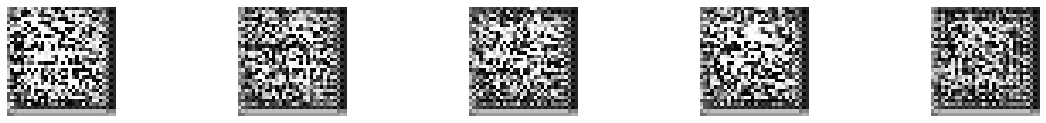

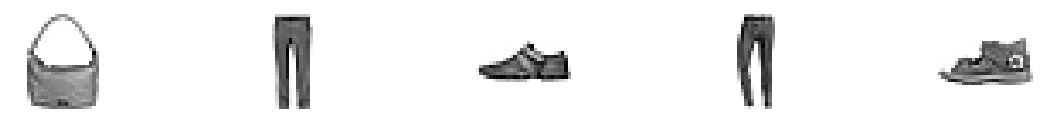

	Epoch 1 	Average Loss:  64.14749634559519 	Reconstruction Loss: 55.94531699589321 	KL Loss: 8.202179486822025


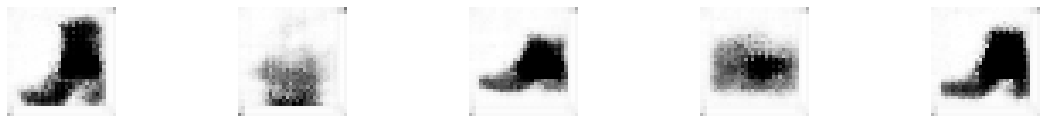

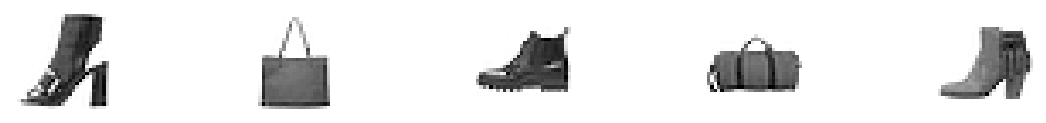

	Epoch 2 	Average Loss:  37.72314081051079 	Reconstruction Loss: 29.438832419259207 	KL Loss: 8.284308385379209


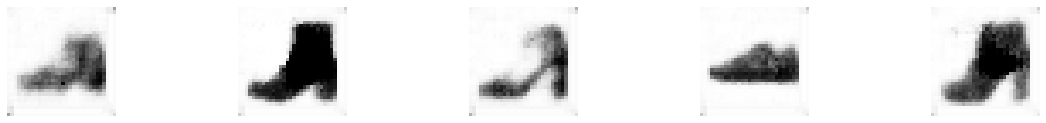

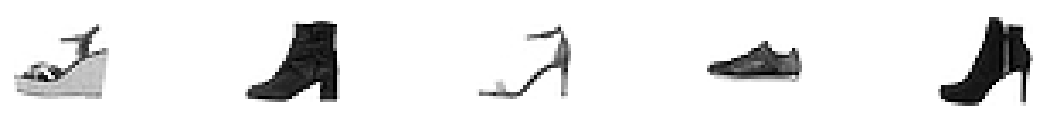

	Epoch 3 	Average Loss:  34.27130790766824 	Reconstruction Loss: 25.75600539522218 	KL Loss: 8.515302486020357


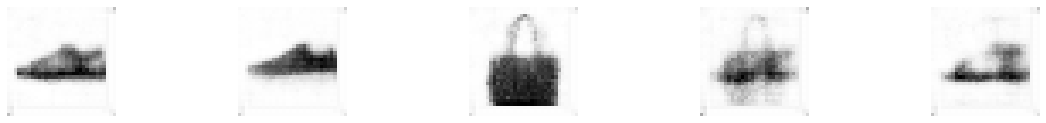

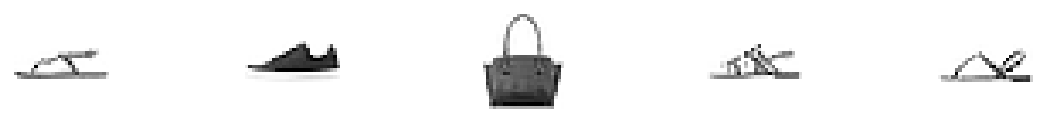

	Epoch 4 	Average Loss:  32.86349287761256 	Reconstruction Loss: 24.29186746991914 	KL Loss: 8.571625447625598


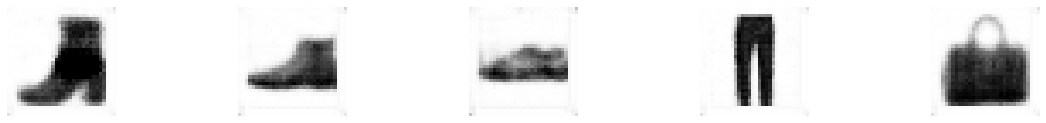

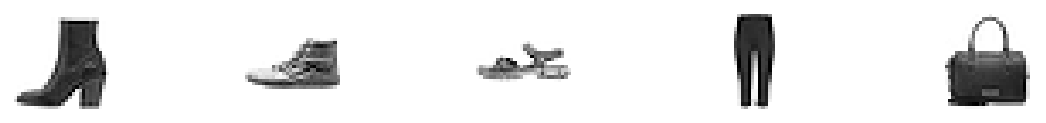

	Epoch 5 	Average Loss:  32.02647927946645 	Reconstruction Loss: 23.399311800895653 	KL Loss: 8.627167532596681


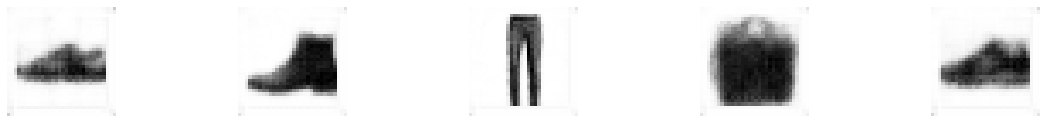

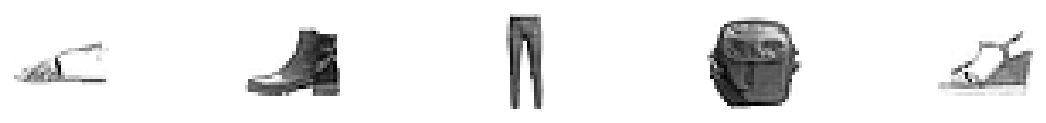

	Epoch 6 	Average Loss:  31.64666088931079 	Reconstruction Loss: 22.900325979505265 	KL Loss: 8.746334940929131


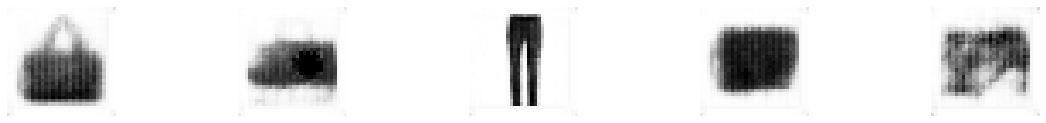

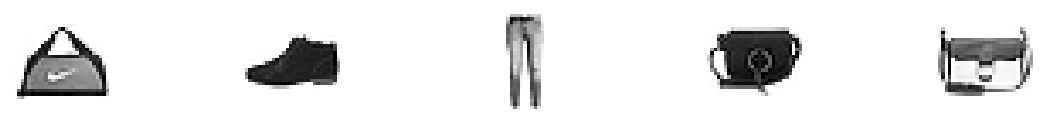

	Epoch 7 	Average Loss:  31.275154891272482 	Reconstruction Loss: 22.546868828129885 	KL Loss: 8.728286082521448


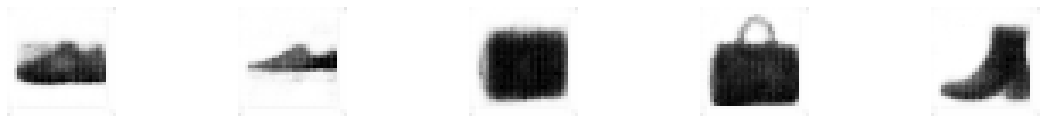

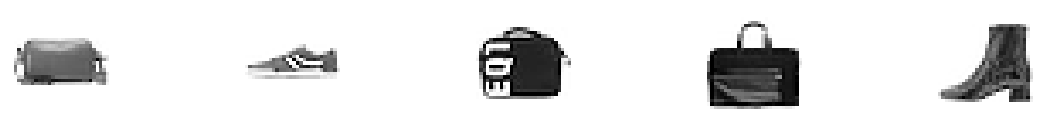

	Epoch 8 	Average Loss:  30.956537467505544 	Reconstruction Loss: 22.199703639364007 	KL Loss: 8.756833767656035


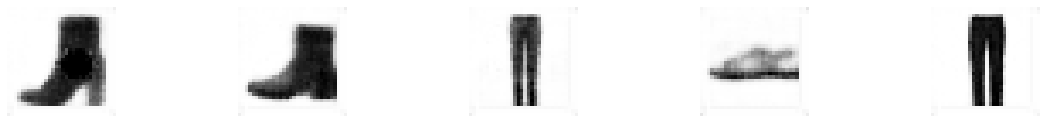

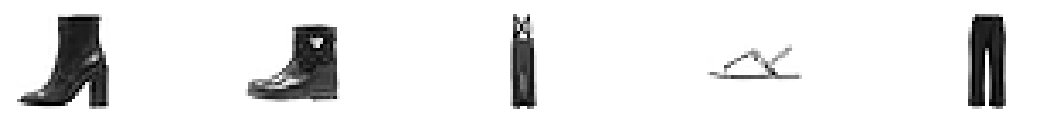

	Epoch 9 	Average Loss:  30.768147844399138 	Reconstruction Loss: 21.963867893359932 	KL Loss: 8.80428002444394


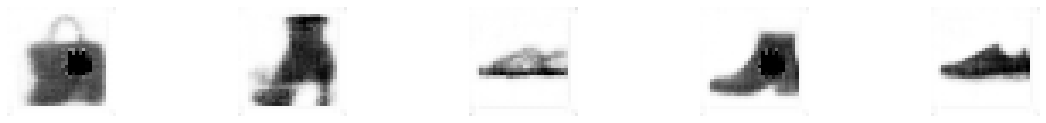

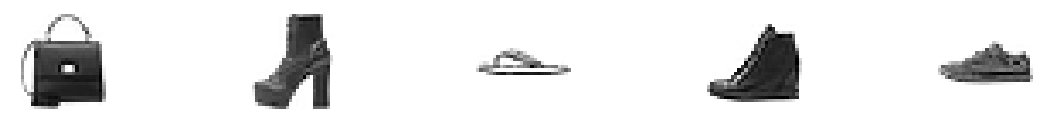

	Epoch 10 	Average Loss:  30.805919567352444 	Reconstruction Loss: 22.05396290952936 	KL Loss: 8.751956624350525


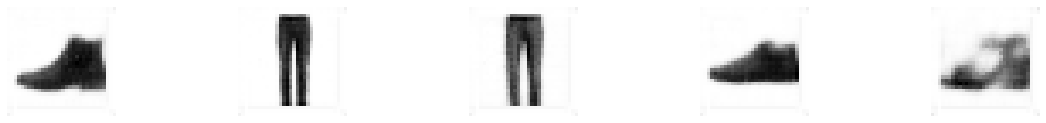

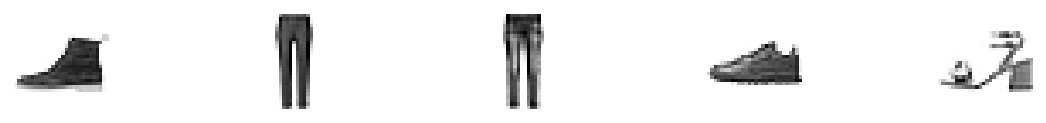

	Epoch 11 	Average Loss:  30.523212747620832 	Reconstruction Loss: 21.762985880151756 	KL Loss: 8.760226826362421


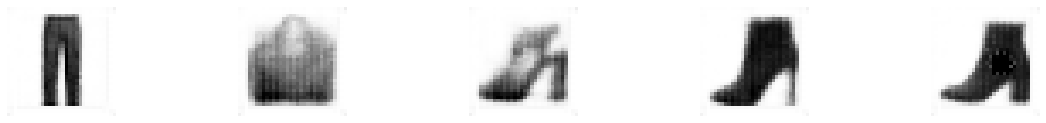

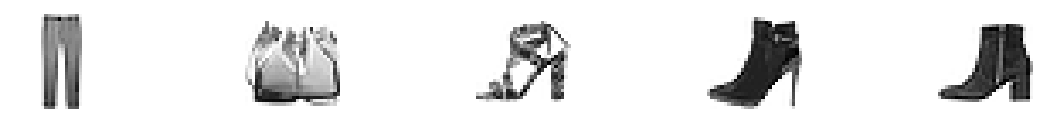

	Epoch 12 	Average Loss:  30.306893791471207 	Reconstruction Loss: 21.51990860201455 	KL Loss: 8.786985158920288


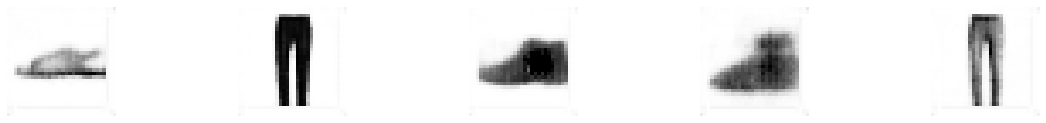

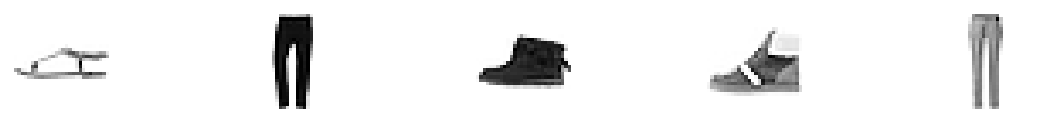

	Epoch 13 	Average Loss:  30.181193307115528 	Reconstruction Loss: 21.396711253180293 	KL Loss: 8.78448207742475


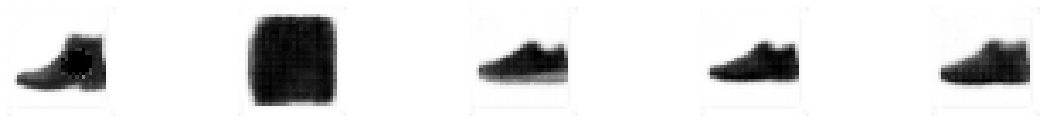

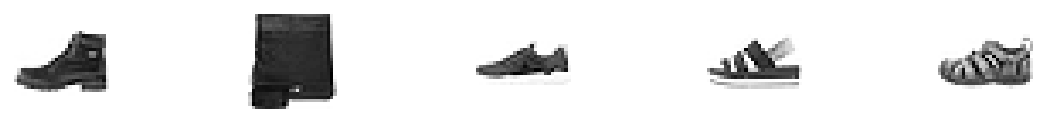

	Epoch 14 	Average Loss:  30.146978899763134 	Reconstruction Loss: 21.30288767579741 	KL Loss: 8.844091188731452


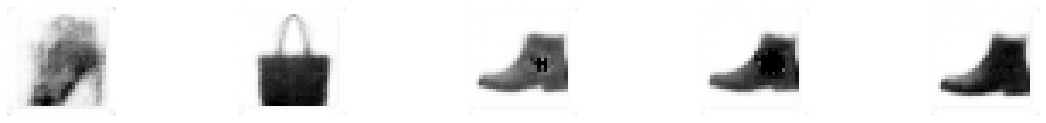

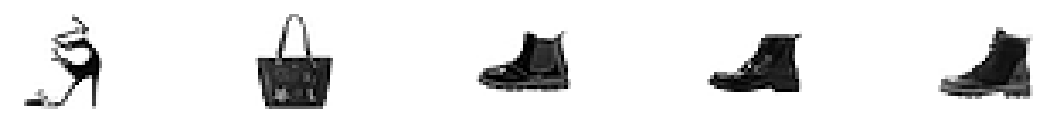

	Epoch 15 	Average Loss:  30.018522640754437 	Reconstruction Loss: 21.211022418120812 	KL Loss: 8.807500251408282


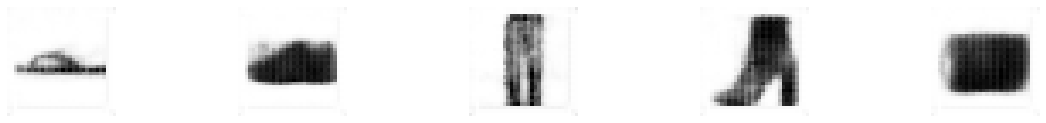

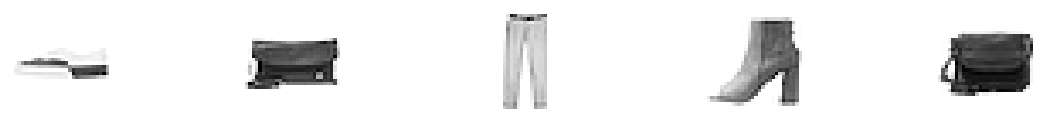

	Epoch 16 	Average Loss:  29.99056498992619 	Reconstruction Loss: 21.149809026953037 	KL Loss: 8.840756001730858


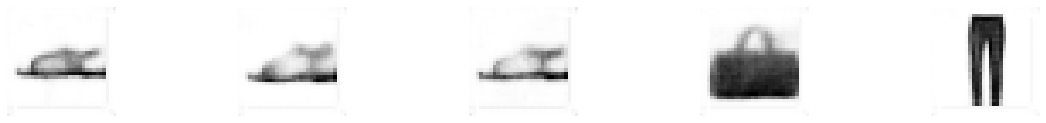

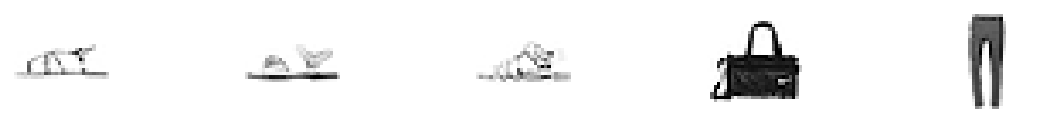

	Epoch 17 	Average Loss:  29.833494759545538 	Reconstruction Loss: 21.010240433838568 	KL Loss: 8.823254350370961


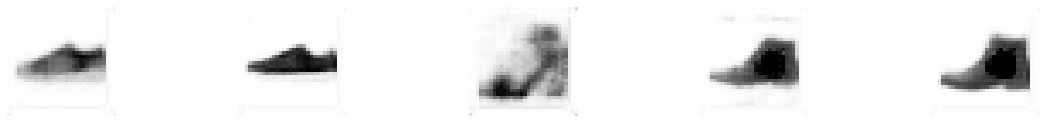

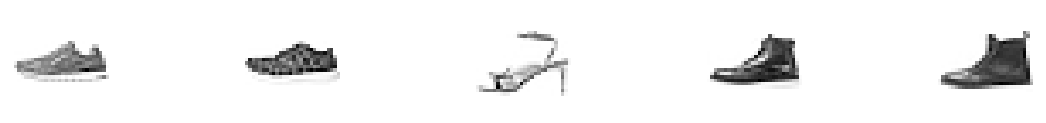

	Epoch 18 	Average Loss:  29.77378435557699 	Reconstruction Loss: 20.914843326718938 	KL Loss: 8.858941039428336


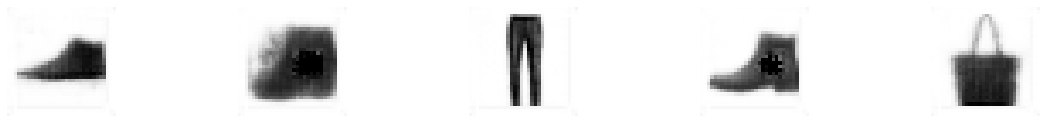

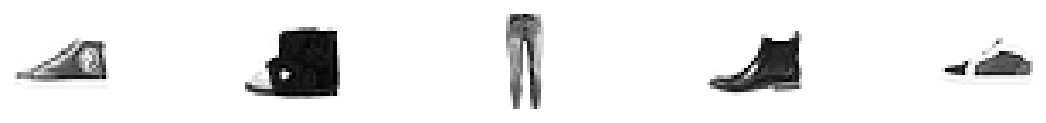

	Epoch 19 	Average Loss:  29.784166408877066 	Reconstruction Loss: 20.8872759565344 	KL Loss: 8.896890444708575


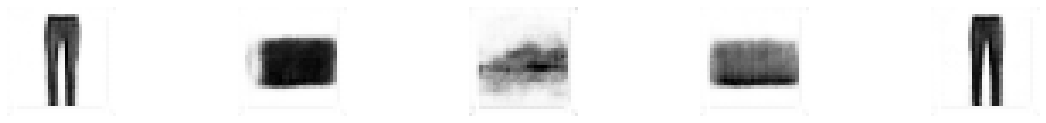

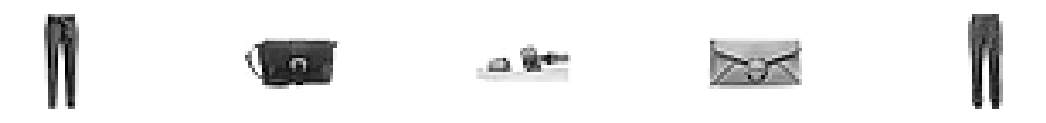

	Epoch 20 	Average Loss:  29.84549837864091 	Reconstruction Loss: 20.903544440058063 	KL Loss: 8.941953943867988


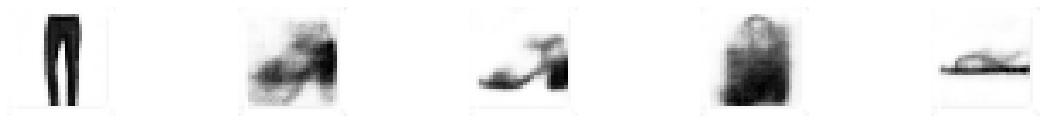

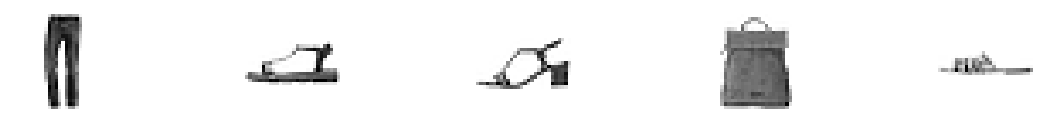

	Epoch 21 	Average Loss:  29.581461307450468 	Reconstruction Loss: 20.66503379027832 	KL Loss: 8.916427540661665


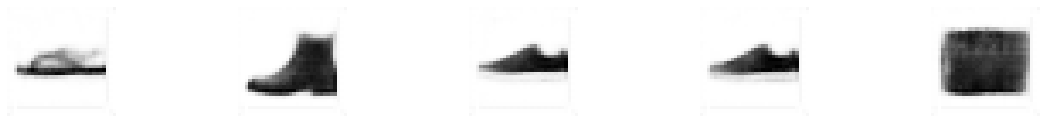

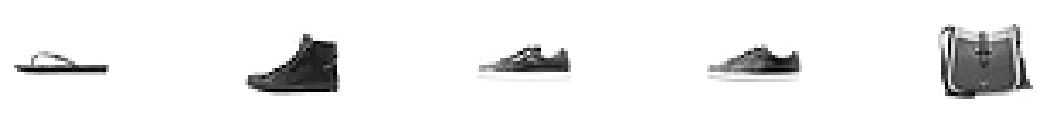

	Epoch 22 	Average Loss:  29.669470347794405 	Reconstruction Loss: 20.73423233877849 	KL Loss: 8.935237981415735


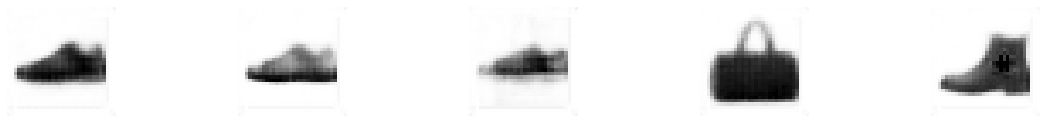

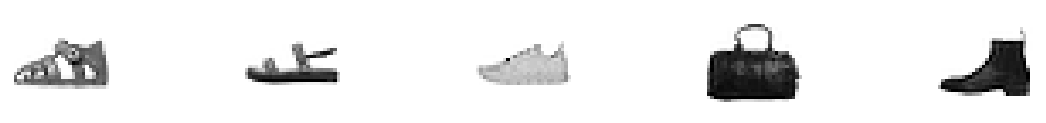

	Epoch 23 	Average Loss:  29.588722204339916 	Reconstruction Loss: 20.630830743629943 	KL Loss: 8.957891524131663


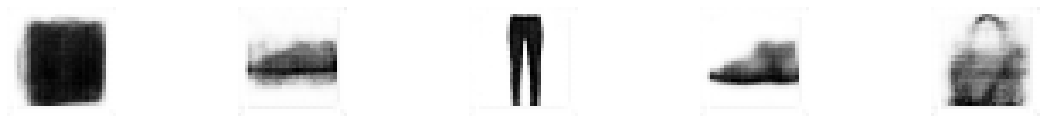

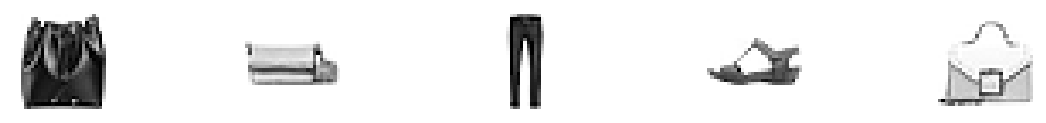

	Epoch 24 	Average Loss:  29.556131113926178 	Reconstruction Loss: 20.632733567007655 	KL Loss: 8.923397540458904


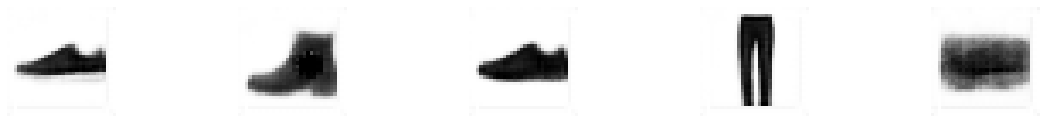

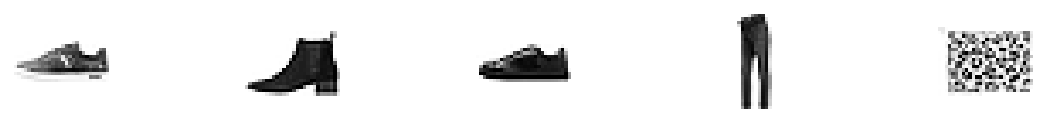

	Epoch 25 	Average Loss:  29.490445928620588 	Reconstruction Loss: 20.52522180350543 	KL Loss: 8.965224111021445


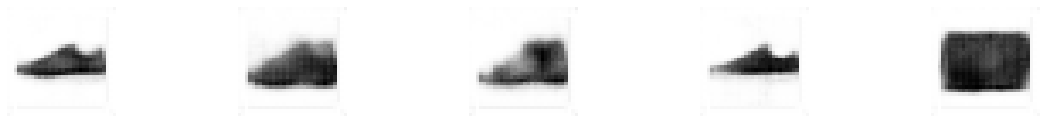

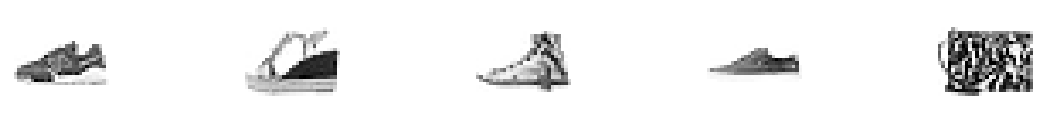

	Epoch 26 	Average Loss:  29.552632879153848 	Reconstruction Loss: 20.602725947431743 	KL Loss: 8.94990695521162


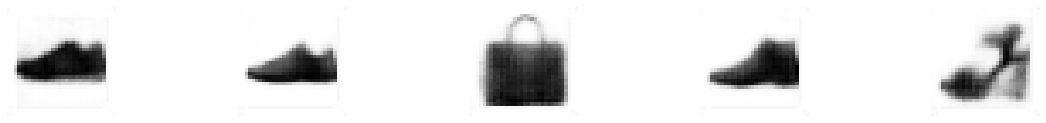

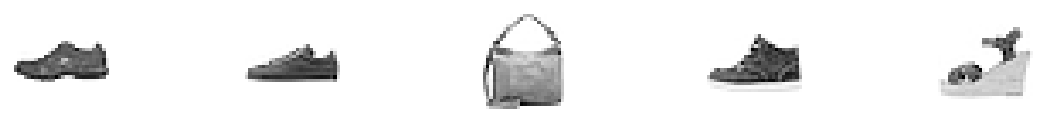

	Epoch 27 	Average Loss:  29.378470541808404 	Reconstruction Loss: 20.4537083550627 	KL Loss: 8.92476221023522


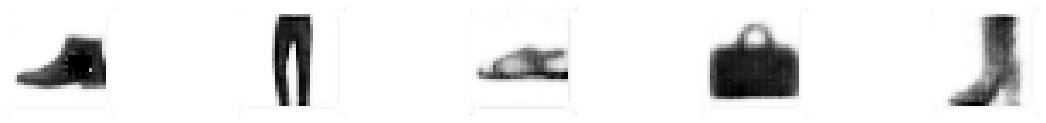

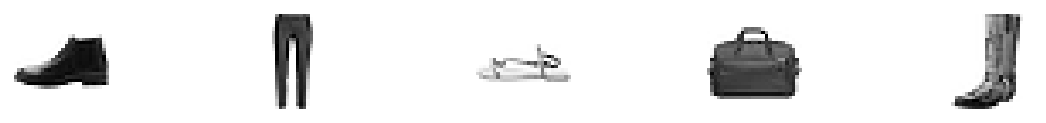

	Epoch 28 	Average Loss:  29.341799966220197 	Reconstruction Loss: 20.404240363924373 	KL Loss: 8.937559608168202


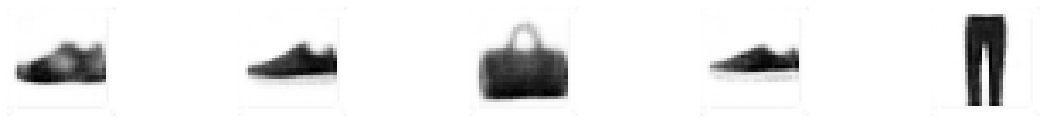

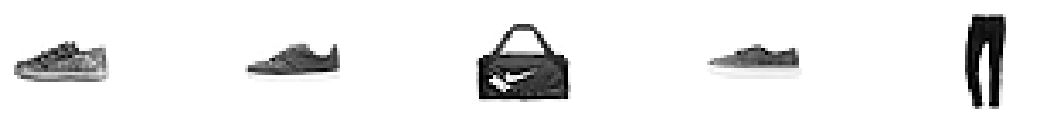

	Epoch 29 	Average Loss:  29.362509680499 	Reconstruction Loss: 20.399677330637214 	KL Loss: 8.96283237570025


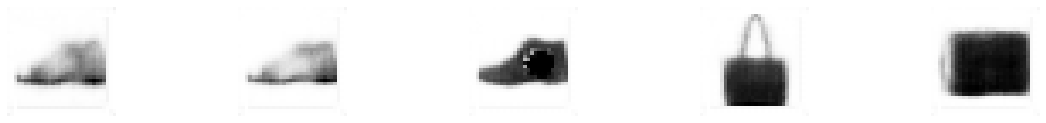

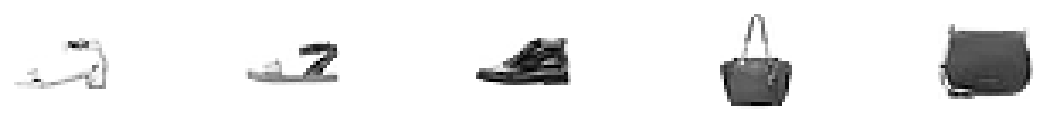

	Epoch 30 	Average Loss:  29.291240514792833 	Reconstruction Loss: 20.343736939829558 	KL Loss: 8.947503567916419


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VAE(device).to(device)

train_model(model, train_dataloader, epochs=30, device=device)

## Classificator Model

In [6]:
class Classificator(nn.Module):
    def __init__(self, encoder, latent_dim=LATENT_DIM, n_classes=5):
        super(Classificator, self).__init__()

        self.encoder = encoder
        self.fc = nn.Linear(latent_dim, n_classes)
        
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std
     
    def forward(self, image):
        mu, logvar = self.encoder(image)
        z = self.reparameterize(mu, logvar)
        out = torch.sigmoid(self.fc(z))
        
        return out, z

## Training Classifier

In [7]:
def train_classifier(encoder, dataloader, criterion, latent_dim=LATENT_DIM, epochs: int = 50, device = torch.device('cpu')):
    encoder = encoder.to(device)
    encoder.eval()

    model = Classificator(encoder, latent_dim).to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

    for epoch in range(epochs):
        correct = 0
        loss_value = 0
        length = 0
        for batch_idx, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)


            optimizer.zero_grad()

            y_pred, noise = model(x)
            loss = criterion(y_pred, y)
            loss_value += loss.item()

            correct += (torch.round(y_pred) == y).all(dim=1).sum().item()
            length += batch_size
            
            loss.backward()
            for p in model.parameters():
                p.register_hook(lambda grad: torch.clamp(grad, -1, 1))
            optimizer.step()
            
        n_datapoints = batch_idx * batch_size
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", loss_value / n_datapoints, '\tCorrectly labeled percentage: ', correct / length)
    return model

def validate_classifier(model, dataloader, device = torch.device('cpu')):

    model.eval()

    correct = 0
    length = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred, noise = model(x)
            correct += (torch.round(y_pred) == y).all(dim=1).sum().item()
            length += x.shape[0]
    print('\tCorrectly labeled percentage: ', correct / length)


In [8]:
criterion = torch.nn.BCELoss()

classifier = train_classifier(model.enc, classification_train_dataloader, criterion, epochs=15, device=device)

	Epoch 1 	Average Loss:  0.009577939791294435 	Correctly labeled percentage:  0.109375
	Epoch 2 	Average Loss:  0.005603474215604365 	Correctly labeled percentage:  0.561875
	Epoch 3 	Average Loss:  0.0030995159613667056 	Correctly labeled percentage:  0.89125
	Epoch 4 	Average Loss:  0.0016996375876866903 	Correctly labeled percentage:  0.94125
	Epoch 5 	Average Loss:  0.0010556405541137792 	Correctly labeled percentage:  0.9575
	Epoch 6 	Average Loss:  0.0007123642911513647 	Correctly labeled percentage:  0.975625
	Epoch 7 	Average Loss:  0.0004820244115156432 	Correctly labeled percentage:  0.98625
	Epoch 8 	Average Loss:  0.00033986560204842436 	Correctly labeled percentage:  0.991875
	Epoch 9 	Average Loss:  0.0002588278051310529 	Correctly labeled percentage:  0.994375
	Epoch 10 	Average Loss:  0.0002021294540099916 	Correctly labeled percentage:  0.995625
	Epoch 11 	Average Loss:  0.00020019846730671512 	Correctly labeled percentage:  0.993125
	Epoch 12 	Average Loss:  0.0001405

In [9]:
validate_classifier(classifier, classification_test_dataloader, device=device)

	Correctly labeled percentage:  0.9325


## Anomaly Detection

In [ ]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = x.shape[1] * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss
    
def anomaly_detection(model, train_dataloader, target_dataloader, device = torch.device('cpu')):
    model.eval()

    elbo_train = []
    elbo_target = []
    rec_train = []
    rec_target = []
    label_target = []

    with torch.no_grad():
        for x, _ in train_dataloader:
            x = x.to(device)
            x_rec, mu, log_sigma = model(x)
            elbo, rec, kl = elbo_elementwise(x.view(x.shape[0], -1), x_rec.view(x.shape[0], -1), mu, log_sigma)
            elbo_train.append(elbo.cpu().numpy())
            rec_train.append(rec.cpu().numpy())
        
        for x, y in target_dataloader:
            x = x.to(device)
            x_rec, mu, log_sigma = model(x)
            elbo, rec, kl = elbo_elementwise(x.view(x.shape[0], -1), x_rec.view(x.shape[0], -1), mu, log_sigma)
            elbo_target.append(elbo.cpu().numpy())
            rec_target.append(rec.cpu().numpy())
            # anomaly class is one in the label list
            label_target.append((y.cpu().numpy().argmax(axis = 1) > 4))

    elbo_train = np.concatenate(elbo_train, 0)
    elbo_target = np.concatenate(elbo_target, 0)
    rec_train = np.concatenate(rec_train, 0)
    rec_target = np.concatenate(rec_target, 0)
    label_target = np.concatenate(label_target, 0)

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].hist(elbo_train, bins=100, color = '#99ccff')
    axs[0].hist(elbo_target[np.where(label_target == False)], bins=100, color = '#bbeeff')
    axs[0].hist(elbo_target[np.where(label_target == True)], bins=100, color = '#cb2c31')
    axs[0].set_title('ELBO')
    
    axs[1].hist(rec_train, bins=100, color = '#99ccff')
    axs[1].hist(rec_target[np.where(label_target == False)], bins=100, color = '#bbeeff')
    axs[1].hist(rec_target[np.where(label_target == True)], bins=100, color = '#cb2c31')
    axs[1].set_title('Reconstruction Loss')
    fig.show()

    scores = -elbo_target
    scores = (scores - scores.min())/(scores.max()-scores.min())

    fpr, tpr, roc_thresholds = roc_curve(label_target, scores)
    precision, recall, pr_thresholds = precision_recall_curve(label_target, scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    print(f'ROC-AUC score: {roc_auc}')
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for anomaly detection')
    plt.legend(loc='lower right')
    plt.show()


    print(f'Precision-Recall score: {pr_auc}')
    plt.figure()
    plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for anomaly detection')
    plt.legend(loc='lower left')
    plt.show() 


ROC-AUC score: 0.9211538461538461


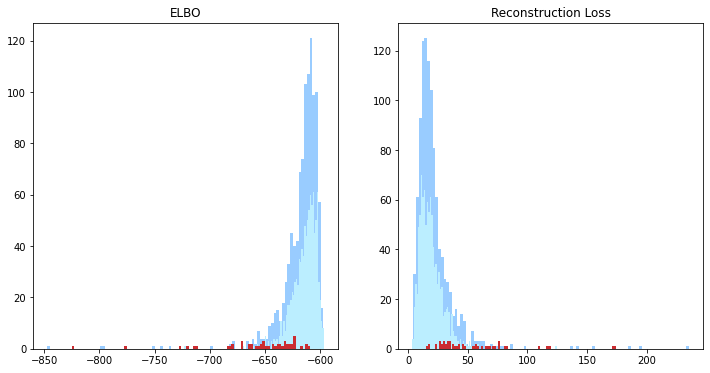

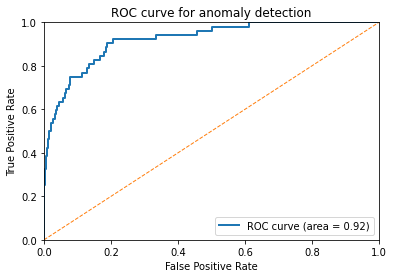

Precision-Recall score: 0.5593638731653454


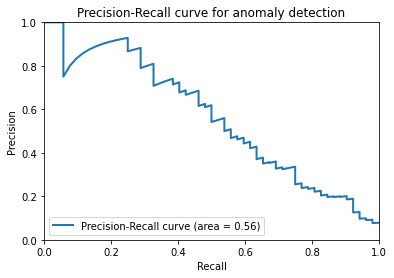

In [ ]:
anomaly_detection(model, anomaly1_dataloader, anomaly2_dataloader, device)